## Loading the dataset

In [1]:
import itertools
import numpy as np

from samples.dataset import Dataset
from samples.sources.maps import MAPS

import tensorflow as tf
from tensorflow import keras

dataset = Dataset()
%time dataset.add_datasource(MAPS('/datasets/audio/maps'))

print('Dataset loaded.')

sample_count = sum(len(note.samples) for note in dataset.notes if note.index > 0)
print('\t{0} samples'.format(sample_count))

Wall time: 373 ms
Dataset loaded.
	2376 samples


## Defining the training data generator

In [2]:
import random

window_size = 4096
batch_size = 32
# batch_size = len([note for note in dataset.notes if note.has_samples()])

class NoteSequence(keras.utils.Sequence):
    def __init__(self, dataset, clip_function, batch_size):
        self.dataset = dataset
        self.clip_function = clip_function
        self.batch_size = batch_size
        
        self.init_epoch()
        
    def init_epoch(self):
        notes = [note for note in dataset.notes if note.has_samples()]
        random.shuffle(notes)
        self.epoch_notes = notes
    
    def on_epoch_end(self):
        self.init_epoch()
        
    def __len__(self):
        # return int(np.ceil(len(self.epoch_notes) / self.batch_size))
        return int(np.floor(len(self.epoch_notes) / self.batch_size))
    
    def __getitem__(self, batch_index):
        batch_notes = self.epoch_notes[(batch_index * self.batch_size) : ((batch_index+1) * self.batch_size)]
        x = [self.clip_function(note) for note in batch_notes]
        labels = [note.index for note in batch_notes]
        y = keras.utils.to_categorical(labels, num_classes = (Dataset.MAX_NOTE_INDEX + 1))
        return tf.squeeze(tf.stack(x)), tf.stack(y)
        # return tf.stack(x), tf.stack(y)

random_clips = lambda note : note.random_sample().get_random_clip(window_size)
onset_clips = lambda note : note.random_sample().get_onset_clip(window_size)
note_sequence = NoteSequence(dataset, random_clips, batch_size)

## Building the model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 4096, 1)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 4094, 122)         488       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4090, 122)         44774     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4082, 122)         44774     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 4066, 122)         44774     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 4034, 122)         44774     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 3970, 122)         4

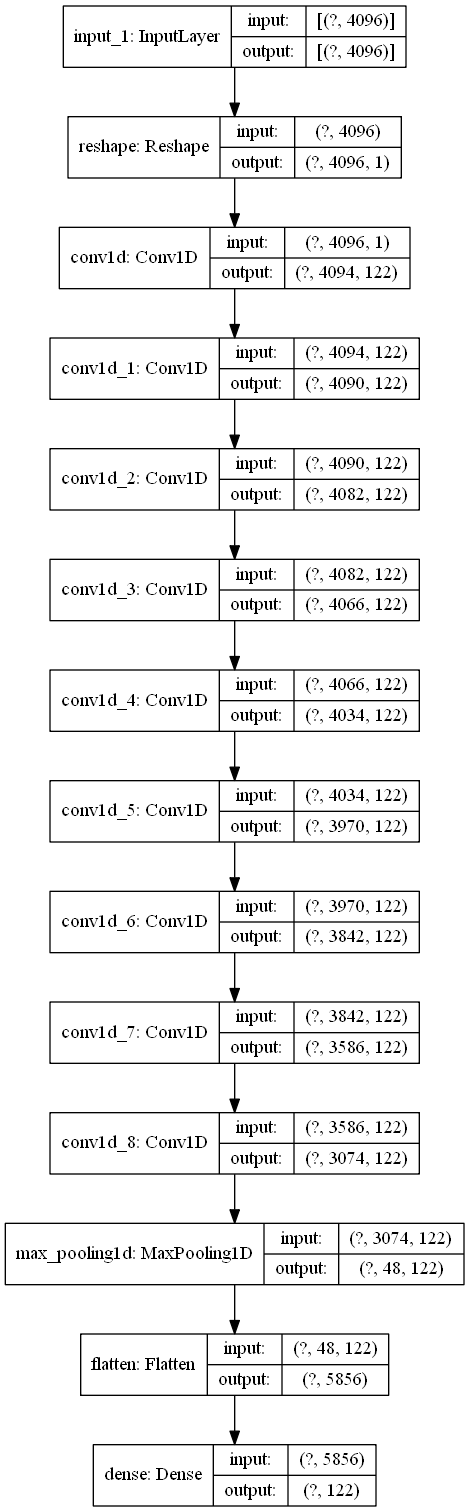

In [3]:
model = keras.Sequential()

model.add(keras.layers.Input(shape=([window_size])))

model.add(keras.layers.Reshape([window_size, 1]))

#model.add(keras.layers.Lambda(tf.signal.rfft))

#model.add(keras.layers.Dense(Dataset.MAX_NOTE_INDEX * 100))
#model.add(keras.layers.Dense(window_size/2, activation="relu"))
#model.add(keras.layers.Dense(window_size/4, activation="relu"))
#model.add(keras.layers.Dense(window_size/8, activation="relu"))
#model.add(keras.layers.LeakyReLU(alpha=1e-5))

#model.add(keras.layers.Conv1D(filters=Dataset.MAX_NOTE_INDEX + 1, kernel_size=1605, activation='relu'))
#model.add(keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'))

convolution_layer_activation = 'linear'

model.add(keras.layers.Conv1D(filters=Dataset.MAX_NOTE_INDEX + 1, kernel_size=3, activation=convolution_layer_activation))
model.add(keras.layers.Conv1D(filters=Dataset.MAX_NOTE_INDEX + 1, kernel_size=3, dilation_rate=2, activation=convolution_layer_activation))
model.add(keras.layers.Conv1D(filters=Dataset.MAX_NOTE_INDEX + 1, kernel_size=3, dilation_rate=4, activation=convolution_layer_activation))
model.add(keras.layers.Conv1D(filters=Dataset.MAX_NOTE_INDEX + 1, kernel_size=3, dilation_rate=8, activation=convolution_layer_activation))
model.add(keras.layers.Conv1D(filters=Dataset.MAX_NOTE_INDEX + 1, kernel_size=3, dilation_rate=16, activation=convolution_layer_activation))
model.add(keras.layers.Conv1D(filters=Dataset.MAX_NOTE_INDEX + 1, kernel_size=3, dilation_rate=32, activation=convolution_layer_activation))
model.add(keras.layers.Conv1D(filters=Dataset.MAX_NOTE_INDEX + 1, kernel_size=3, dilation_rate=64, activation=convolution_layer_activation))
model.add(keras.layers.Conv1D(filters=Dataset.MAX_NOTE_INDEX + 1, kernel_size=3, dilation_rate=128, activation=convolution_layer_activation))
model.add(keras.layers.Conv1D(filters=Dataset.MAX_NOTE_INDEX + 1, kernel_size=3, dilation_rate=256, activation=convolution_layer_activation))

#model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.MaxPooling1D(pool_size=64))
#model.add(keras.layers.MaxPooling1D(pool_size=1605))
model.add(keras.layers.Flatten())

# model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Dense(Dataset.MAX_NOTE_INDEX + 1, activation='softmax'))

model.compile(optimizer=keras.optimizers.Adam(clipnorm=1),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()
keras.utils.plot_model(model, show_shapes=True)

## Training

In [4]:
# history = model.fit(xx, yy, epochs=100, use_multiprocessing=True, workers=8)
# history = model.fit(note_sequence, epochs=100, use_multiprocessing=True, workers=8)
%time history = model.fit(note_sequence, epochs=1000)
# history = model.train_on_batch(xx, yy)

Epoch 1/1000
2/2 [==============================] - 0s 103ms/step - loss: 4.8076 - accuracy: 0.0156
Epoch 2/1000
2/2 [==============================] - 0s 236ms/step - loss: 4.8449 - accuracy: 0.0156
Epoch 3/1000
2/2 [==============================] - 0s 232ms/step - loss: 4.7640 - accuracy: 0.0000e+00
Epoch 4/1000
2/2 [==============================] - 0s 229ms/step - loss: 4.6914 - accuracy: 0.0156
Epoch 5/1000
2/2 [==============================] - 0s 234ms/step - loss: 4.6814 - accuracy: 0.0156
Epoch 6/1000
2/2 [==============================] - 0s 229ms/step - loss: 4.6694 - accuracy: 0.0312
Epoch 7/1000
2/2 [==============================] - 0s 224ms/step - loss: 4.6090 - accuracy: 0.0156
Epoch 8/1000
2/2 [==============================] - 0s 221ms/step - loss: 4.5456 - accuracy: 0.0156
Epoch 9/1000
2/2 [==============================] - 0s 221ms/step - loss: 4.5253 - accuracy: 0.0156
Epoch 10/1000
2/2 [==============================] - 0s 214ms/step - loss: 4.4642 - accuracy: 0.

2/2 [==============================] - 0s 169ms/step - loss: 3.3963 - accuracy: 0.2188
Epoch 80/1000
2/2 [==============================] - 0s 175ms/step - loss: 2.8128 - accuracy: 0.3281
Epoch 81/1000
2/2 [==============================] - 0s 172ms/step - loss: 3.4569 - accuracy: 0.2344
Epoch 82/1000
2/2 [==============================] - 0s 166ms/step - loss: 3.6757 - accuracy: 0.2031
Epoch 83/1000
2/2 [==============================] - 0s 179ms/step - loss: 3.2329 - accuracy: 0.2812
Epoch 84/1000
2/2 [==============================] - 0s 168ms/step - loss: 3.5676 - accuracy: 0.3281
Epoch 85/1000
2/2 [==============================] - 0s 168ms/step - loss: 3.8487 - accuracy: 0.2344
Epoch 86/1000
2/2 [==============================] - 0s 171ms/step - loss: 3.4656 - accuracy: 0.2188
Epoch 87/1000
2/2 [==============================] - 0s 176ms/step - loss: 3.4385 - accuracy: 0.2656
Epoch 88/1000
2/2 [==============================] - 0s 167ms/step - loss: 3.5594 - accuracy: 0.1562
Epoc

2/2 [==============================] - 0s 167ms/step - loss: 3.8156 - accuracy: 0.1875
Epoch 160/1000
2/2 [==============================] - 0s 167ms/step - loss: 2.5459 - accuracy: 0.4375
Epoch 161/1000
2/2 [==============================] - 0s 165ms/step - loss: 2.5697 - accuracy: 0.3750
Epoch 162/1000
2/2 [==============================] - 0s 167ms/step - loss: 2.9919 - accuracy: 0.4062
Epoch 163/1000
2/2 [==============================] - 0s 168ms/step - loss: 2.7507 - accuracy: 0.3438
Epoch 164/1000
2/2 [==============================] - 0s 165ms/step - loss: 2.5023 - accuracy: 0.4688
Epoch 165/1000
2/2 [==============================] - 0s 167ms/step - loss: 2.5963 - accuracy: 0.3750
Epoch 166/1000
2/2 [==============================] - 0s 166ms/step - loss: 3.1733 - accuracy: 0.3594
Epoch 167/1000
2/2 [==============================] - 0s 167ms/step - loss: 2.5334 - accuracy: 0.4062
Epoch 168/1000
2/2 [==============================] - 0s 167ms/step - loss: 2.6261 - accuracy: 0.

2/2 [==============================] - 0s 168ms/step - loss: 2.5360 - accuracy: 0.4531
Epoch 240/1000
2/2 [==============================] - 0s 167ms/step - loss: 2.6536 - accuracy: 0.4375
Epoch 241/1000
2/2 [==============================] - 0s 167ms/step - loss: 2.1074 - accuracy: 0.4844
Epoch 242/1000
2/2 [==============================] - 0s 166ms/step - loss: 2.8279 - accuracy: 0.4062
Epoch 243/1000
2/2 [==============================] - 0s 167ms/step - loss: 3.0082 - accuracy: 0.4219
Epoch 244/1000
2/2 [==============================] - 0s 167ms/step - loss: 2.3763 - accuracy: 0.4688
Epoch 245/1000
2/2 [==============================] - 0s 166ms/step - loss: 2.7580 - accuracy: 0.3438
Epoch 246/1000
2/2 [==============================] - 0s 167ms/step - loss: 2.8980 - accuracy: 0.3906
Epoch 247/1000
2/2 [==============================] - 0s 155ms/step - loss: 2.5227 - accuracy: 0.5000
Epoch 248/1000
2/2 [==============================] - 0s 166ms/step - loss: 2.3885 - accuracy: 0.

2/2 [==============================] - 0s 169ms/step - loss: 2.6722 - accuracy: 0.3750
Epoch 320/1000
2/2 [==============================] - 0s 164ms/step - loss: 2.2338 - accuracy: 0.5000
Epoch 321/1000
2/2 [==============================] - 0s 167ms/step - loss: 2.4684 - accuracy: 0.4219
Epoch 322/1000
2/2 [==============================] - 0s 165ms/step - loss: 2.4854 - accuracy: 0.4688
Epoch 323/1000
2/2 [==============================] - 0s 173ms/step - loss: 2.1587 - accuracy: 0.4844
Epoch 324/1000
2/2 [==============================] - 0s 173ms/step - loss: 2.2846 - accuracy: 0.5469
Epoch 325/1000
2/2 [==============================] - 0s 167ms/step - loss: 2.2026 - accuracy: 0.5625
Epoch 326/1000
2/2 [==============================] - 0s 171ms/step - loss: 2.8821 - accuracy: 0.4688
Epoch 327/1000
2/2 [==============================] - 0s 165ms/step - loss: 2.4569 - accuracy: 0.4531
Epoch 328/1000
2/2 [==============================] - 0s 167ms/step - loss: 2.1598 - accuracy: 0.

2/2 [==============================] - 0s 168ms/step - loss: 1.8601 - accuracy: 0.5312
Epoch 400/1000
2/2 [==============================] - 0s 166ms/step - loss: 1.8426 - accuracy: 0.6094
Epoch 401/1000
2/2 [==============================] - 0s 166ms/step - loss: 1.8249 - accuracy: 0.5625
Epoch 402/1000
2/2 [==============================] - 0s 166ms/step - loss: 1.8468 - accuracy: 0.5312
Epoch 403/1000
2/2 [==============================] - 0s 169ms/step - loss: 1.7551 - accuracy: 0.5312
Epoch 404/1000
2/2 [==============================] - 0s 165ms/step - loss: 2.4055 - accuracy: 0.5156
Epoch 405/1000
2/2 [==============================] - 0s 156ms/step - loss: 2.6809 - accuracy: 0.4688
Epoch 406/1000
2/2 [==============================] - 0s 166ms/step - loss: 1.6279 - accuracy: 0.6406
Epoch 407/1000
2/2 [==============================] - 0s 166ms/step - loss: 1.4969 - accuracy: 0.6562
Epoch 408/1000
2/2 [==============================] - 0s 167ms/step - loss: 3.2900 - accuracy: 0.

2/2 [==============================] - 0s 167ms/step - loss: 2.0943 - accuracy: 0.5469
Epoch 480/1000
2/2 [==============================] - 0s 167ms/step - loss: 1.9182 - accuracy: 0.5625
Epoch 481/1000
2/2 [==============================] - 0s 167ms/step - loss: 2.3292 - accuracy: 0.5469
Epoch 482/1000
2/2 [==============================] - 0s 158ms/step - loss: 2.3003 - accuracy: 0.5312
Epoch 483/1000
2/2 [==============================] - 0s 179ms/step - loss: 2.6668 - accuracy: 0.4062
Epoch 484/1000
2/2 [==============================] - 0s 166ms/step - loss: 1.8384 - accuracy: 0.6094
Epoch 485/1000
2/2 [==============================] - 0s 168ms/step - loss: 1.4903 - accuracy: 0.6250
Epoch 486/1000
2/2 [==============================] - 0s 166ms/step - loss: 1.6148 - accuracy: 0.6250
Epoch 487/1000
2/2 [==============================] - 0s 167ms/step - loss: 2.1262 - accuracy: 0.5938
Epoch 488/1000
2/2 [==============================] - 0s 148ms/step - loss: 1.8194 - accuracy: 0.

2/2 [==============================] - 0s 173ms/step - loss: 1.8252 - accuracy: 0.5781
Epoch 560/1000
2/2 [==============================] - 0s 172ms/step - loss: 2.3729 - accuracy: 0.5156
Epoch 561/1000
2/2 [==============================] - 0s 165ms/step - loss: 2.2406 - accuracy: 0.5469
Epoch 562/1000
2/2 [==============================] - 0s 167ms/step - loss: 1.9998 - accuracy: 0.5000
Epoch 563/1000
2/2 [==============================] - 0s 173ms/step - loss: 2.2875 - accuracy: 0.5156
Epoch 564/1000
2/2 [==============================] - 0s 154ms/step - loss: 1.8946 - accuracy: 0.5781
Epoch 565/1000
2/2 [==============================] - 0s 167ms/step - loss: 1.7108 - accuracy: 0.6406
Epoch 566/1000
2/2 [==============================] - 0s 165ms/step - loss: 2.1109 - accuracy: 0.5000
Epoch 567/1000
2/2 [==============================] - 0s 166ms/step - loss: 2.5214 - accuracy: 0.5156
Epoch 568/1000
2/2 [==============================] - 0s 166ms/step - loss: 1.9889 - accuracy: 0.

2/2 [==============================] - 0s 164ms/step - loss: 2.2302 - accuracy: 0.5156
Epoch 640/1000
2/2 [==============================] - 0s 167ms/step - loss: 1.7649 - accuracy: 0.5938
Epoch 641/1000
2/2 [==============================] - 0s 166ms/step - loss: 1.4370 - accuracy: 0.6875
Epoch 642/1000
2/2 [==============================] - 0s 165ms/step - loss: 1.4348 - accuracy: 0.6562
Epoch 643/1000
2/2 [==============================] - 0s 170ms/step - loss: 1.6756 - accuracy: 0.5938
Epoch 644/1000
2/2 [==============================] - 0s 166ms/step - loss: 2.3162 - accuracy: 0.5469
Epoch 645/1000
2/2 [==============================] - 0s 167ms/step - loss: 2.0591 - accuracy: 0.5781
Epoch 646/1000
2/2 [==============================] - 0s 165ms/step - loss: 2.4703 - accuracy: 0.5156
Epoch 647/1000
2/2 [==============================] - 0s 176ms/step - loss: 1.7587 - accuracy: 0.6094
Epoch 648/1000
2/2 [==============================] - 0s 157ms/step - loss: 1.4599 - accuracy: 0.

2/2 [==============================] - 0s 172ms/step - loss: 1.8865 - accuracy: 0.5938
Epoch 720/1000
2/2 [==============================] - 0s 120ms/step - loss: 2.8318 - accuracy: 0.4688
Epoch 721/1000
2/2 [==============================] - 0s 166ms/step - loss: 1.8940 - accuracy: 0.5469
Epoch 722/1000
2/2 [==============================] - 0s 174ms/step - loss: 1.8148 - accuracy: 0.6094
Epoch 723/1000
2/2 [==============================] - 0s 168ms/step - loss: 1.9436 - accuracy: 0.5156
Epoch 724/1000
2/2 [==============================] - 0s 174ms/step - loss: 2.0933 - accuracy: 0.4844
Epoch 725/1000
2/2 [==============================] - 0s 156ms/step - loss: 1.8917 - accuracy: 0.5469
Epoch 726/1000
2/2 [==============================] - 0s 167ms/step - loss: 1.6427 - accuracy: 0.6250
Epoch 727/1000
2/2 [==============================] - 0s 166ms/step - loss: 1.5605 - accuracy: 0.5938
Epoch 728/1000
2/2 [==============================] - 0s 167ms/step - loss: 2.6015 - accuracy: 0.

2/2 [==============================] - 0s 178ms/step - loss: 2.2815 - accuracy: 0.5469
Epoch 800/1000
2/2 [==============================] - 0s 172ms/step - loss: 1.7305 - accuracy: 0.6406
Epoch 801/1000
2/2 [==============================] - 0s 167ms/step - loss: 2.1120 - accuracy: 0.5469
Epoch 802/1000
2/2 [==============================] - 0s 163ms/step - loss: 1.3649 - accuracy: 0.6562
Epoch 803/1000
2/2 [==============================] - 0s 168ms/step - loss: 1.8632 - accuracy: 0.5625
Epoch 804/1000
2/2 [==============================] - 0s 167ms/step - loss: 2.0210 - accuracy: 0.5312
Epoch 805/1000
2/2 [==============================] - 0s 169ms/step - loss: 2.0997 - accuracy: 0.5938
Epoch 806/1000
2/2 [==============================] - 0s 167ms/step - loss: 1.4925 - accuracy: 0.5938
Epoch 807/1000
2/2 [==============================] - 0s 165ms/step - loss: 1.3426 - accuracy: 0.6562
Epoch 808/1000
2/2 [==============================] - 0s 167ms/step - loss: 2.7085 - accuracy: 0.

2/2 [==============================] - 0s 167ms/step - loss: 1.5954 - accuracy: 0.6875
Epoch 880/1000
2/2 [==============================] - 0s 171ms/step - loss: 2.1393 - accuracy: 0.6250
Epoch 881/1000
2/2 [==============================] - 0s 167ms/step - loss: 1.2534 - accuracy: 0.6875
Epoch 882/1000
2/2 [==============================] - 0s 170ms/step - loss: 1.9190 - accuracy: 0.6094
Epoch 883/1000
2/2 [==============================] - 0s 168ms/step - loss: 1.6960 - accuracy: 0.7031
Epoch 884/1000
2/2 [==============================] - 0s 172ms/step - loss: 1.7130 - accuracy: 0.5625
Epoch 885/1000
2/2 [==============================] - 0s 174ms/step - loss: 2.2551 - accuracy: 0.5469
Epoch 886/1000
2/2 [==============================] - 0s 166ms/step - loss: 1.7291 - accuracy: 0.6094
Epoch 887/1000
2/2 [==============================] - 0s 174ms/step - loss: 1.6966 - accuracy: 0.5938
Epoch 888/1000
2/2 [==============================] - 0s 167ms/step - loss: 2.2268 - accuracy: 0.

2/2 [==============================] - 0s 156ms/step - loss: 2.5480 - accuracy: 0.6719
Epoch 960/1000
2/2 [==============================] - 0s 167ms/step - loss: 2.1729 - accuracy: 0.5625
Epoch 961/1000
2/2 [==============================] - 0s 166ms/step - loss: 1.7071 - accuracy: 0.6406
Epoch 962/1000
2/2 [==============================] - 0s 170ms/step - loss: 1.9400 - accuracy: 0.5781
Epoch 963/1000
2/2 [==============================] - 0s 166ms/step - loss: 2.0832 - accuracy: 0.5000
Epoch 964/1000
2/2 [==============================] - 0s 167ms/step - loss: 2.0177 - accuracy: 0.5312
Epoch 965/1000
2/2 [==============================] - 0s 153ms/step - loss: 1.8891 - accuracy: 0.5781
Epoch 966/1000
2/2 [==============================] - 0s 167ms/step - loss: 1.4442 - accuracy: 0.6875
Epoch 967/1000
2/2 [==============================] - 0s 155ms/step - loss: 1.6113 - accuracy: 0.6406
Epoch 968/1000
2/2 [==============================] - 0s 168ms/step - loss: 1.7123 - accuracy: 0.

## Displaying the training stats

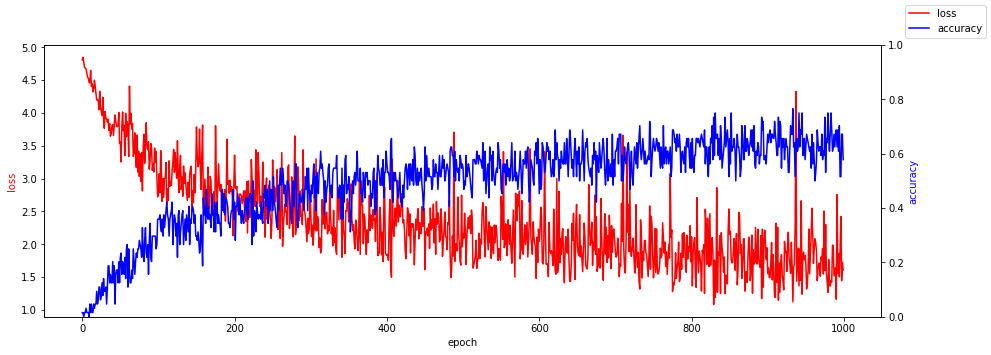

In [5]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss', color='red')

ax2 = ax1.twinx()
ax2.set_ylabel('accuracy', color='blue')
ax2.set_ylim(0, 1)

ax1.plot(history.history['loss'], label='loss', color='red')
ax2.plot(history.history['accuracy'], label='accuracy', color='blue')
fig.legend()
plt.show()

## Evaluating the trained model

In [6]:
import pandas as pd

note_times = [x/1000 for x in range(0, 1000, 100)]

all_samples = ((note.index,
                time,
                [sample.get_clip_at_t(time, window_size) for sample in note.samples],
                [note.index for sample in note.samples]
               )
               for note in dataset.notes if note.index > 0 and note.has_samples() for time in note_times)

scores = [(index,
           time,
           model.evaluate(tf.squeeze(clips), keras.utils.to_categorical(labels, num_classes = (Dataset.MAX_NOTE_INDEX + 1)), verbose=0))
          for (index, time, clips, labels) in all_samples]

score_data = pd.DataFrame(((note, time, score[0], score[1]) for (note, time, score) in scores), columns=['Note', 'Time', 'Loss', 'Accuracy'])

score_data.head()

,Note,Time,Loss,Accuracy
0,10,0.0,7.725698,0.518519
1,10,0.1,6.877964,0.407407
2,10,0.2,4.921183,0.444444
3,10,0.3,4.407256,0.481481
4,10,0.4,5.098129,0.407407


### Plotting the results

<AxesSubplot:xlabel='Time'>

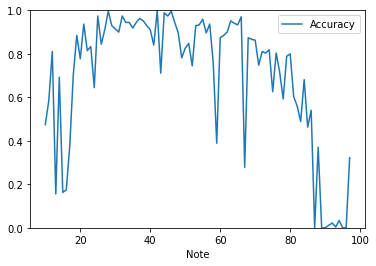

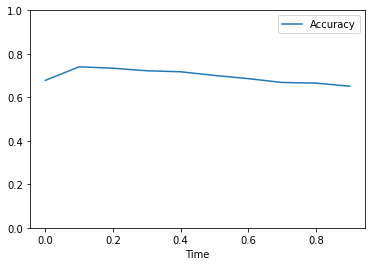

In [7]:
note_accuracy = score_data[['Note', 'Accuracy']].groupby('Note').mean()
note_accuracy.plot(ylim=(0,1))

time_accuracy = score_data[['Time', 'Accuracy']].groupby('Time').mean()
time_accuracy.plot(ylim=(0,1))

<AxesSubplot:xlabel='Time'>

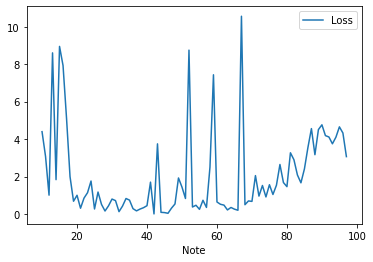

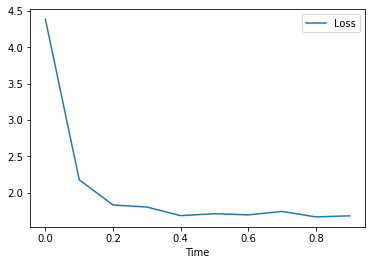

In [8]:
note_accuracy = score_data[['Note', 'Loss']].groupby('Note').mean()
note_accuracy.plot()

time_accuracy = score_data[['Time', 'Loss']].groupby('Time').mean()
time_accuracy.plot()

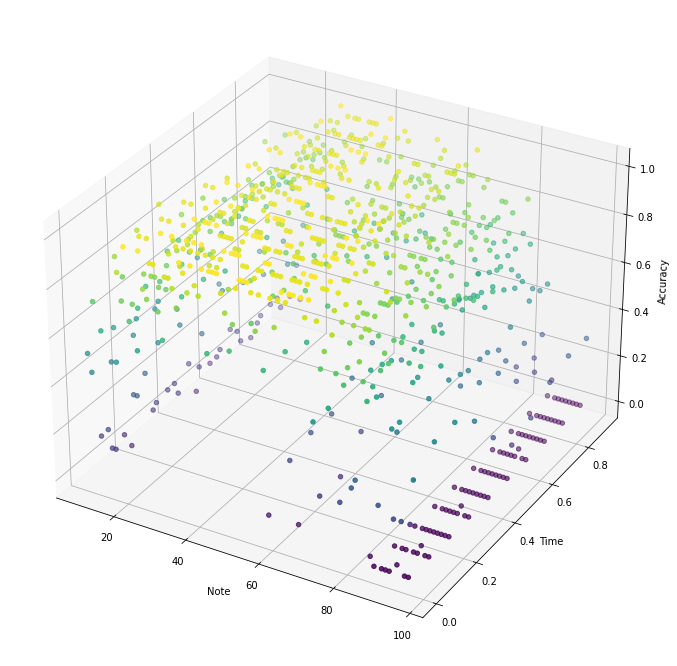

In [9]:
from mpl_toolkits import mplot3d

note_time_accuracy = score_data[['Note', 'Time', 'Accuracy']].groupby(['Note', 'Time'], as_index=False).mean()

fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection='3d')

ax.scatter3D(note_time_accuracy['Note'],
             note_time_accuracy['Time'],
             note_time_accuracy['Accuracy'],
             c=note_time_accuracy['Accuracy'], cmap='viridis')

ax.set_xlabel('Note')
ax.set_ylabel('Time')
ax.set_zlabel('Accuracy')
plt.show()
